# Identify Fraud from Enron Email

**In this project I'll try to use different classfiers to predict poi in Enron dataset. I'll perform feature selection, outliers removal, creating new features, scale features and select best features. Pipelines will be built for different classfiers and their performance will be tuned and validated for final results. Finally, the best model will be dumped.**

**First, let's import the packages we need.**

In [31]:
import sys
import pickle
sys.path.append("../tools/")
import matplotlib.pyplot as plt
from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

import tester
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest,f_classif
from sklearn.cross_validation import train_test_split, StratifiedShuffleSplit
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
%matplotlib inline



**First, I'll select the features I'll use and load the dataset.**

In [3]:
### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".
features_list = ['poi','salary',
                 'bonus','deferral_payments',
                 'deferred_income','director_fees',
                 'exercised_stock_options','expenses',
                 'loan_advances', 'long_term_incentive',
                 'other','restricted_stock',
                 'restricted_stock_deferred', 'total_payments',
                 'total_stock_value','from_messages',
                 'from_poi_to_this_person','from_this_person_to_poi',
                 'shared_receipt_with_poi','to_messages'] 


In [4]:
### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

## Dataset Exploration

In [5]:
data_dict_df = pd.DataFrame.from_dict(data_dict, orient = 'index')

In [6]:
data_dict_df = data_dict_df.replace('NaN', np.nan)
data_dict_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 146 entries, ALLEN PHILLIP K to YEAP SOON
Data columns (total 21 columns):
salary                       95 non-null float64
to_messages                  86 non-null float64
deferral_payments            39 non-null float64
total_payments               125 non-null float64
exercised_stock_options      102 non-null float64
bonus                        82 non-null float64
restricted_stock             110 non-null float64
shared_receipt_with_poi      86 non-null float64
restricted_stock_deferred    18 non-null float64
total_stock_value            126 non-null float64
expenses                     95 non-null float64
loan_advances                4 non-null float64
from_messages                86 non-null float64
other                        93 non-null float64
from_this_person_to_poi      86 non-null float64
poi                          146 non-null bool
director_fees                17 non-null float64
deferred_income              49 non-null float

In [7]:
data_dict_df['poi'].value_counts()

False    128
True      18
Name: poi, dtype: int64

**As we can see, there are 146 data points. There are 128 non-POI and 18 poi. We have 21 features initially. All other features have missing values except the poi feature. The email_address feature should be removed since it may not be helpful.**

## Visualize and Remove Outliers

**Now it's important to visualize and find out the outliers before the analysis. I'll plot the outliers and find them in the pdf document.**

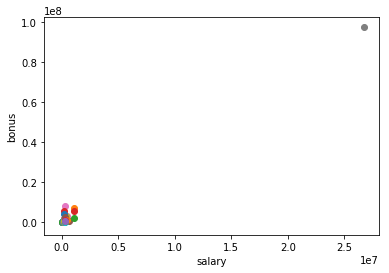

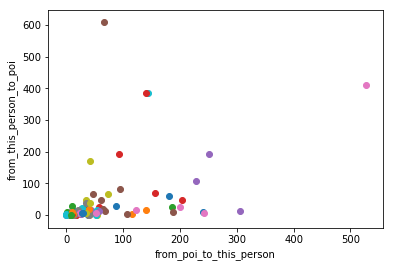

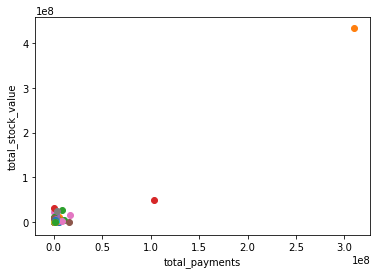

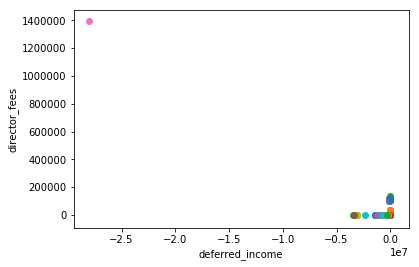

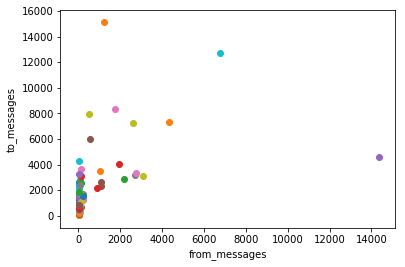

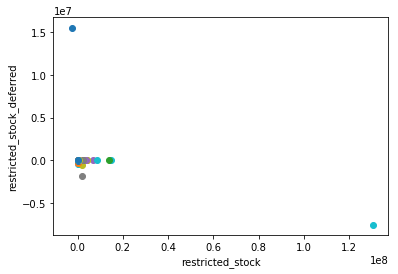

In [8]:
### Task 2: Remove outliers


def plotoutliers(data_dict, feature_x, feature_y):
    """ Plot with flag = True in Red """
    data = featureFormat(data_dict, [feature_x, feature_y])
    for point in data:
        x = point[0]
        y = point[1]        
        plt.scatter(x, y)
    plt.xlabel(feature_x)
    plt.ylabel(feature_y)
    plt.show()

plotoutliers(data_dict, 'salary', 'bonus')
plotoutliers(data_dict, 'from_poi_to_this_person', 'from_this_person_to_poi')
plotoutliers(data_dict, 'total_payments', 'total_stock_value')
plotoutliers(data_dict, 'deferred_income','director_fees')
plotoutliers(data_dict, 'from_messages', 'to_messages')
plotoutliers(data_dict, 'restricted_stock', 'restricted_stock_deferred')




In [9]:
print (data_dict['LAY KENNETH L']['poi'])
print(data_dict['WHITE JR THOMAS E']['poi'])
print(data_dict['LOCKHART EUGENE E']['poi'])
outliers=['TOTAL','WHITE JR THOMAS E','LOCKHART EUGENE E', 'THE TRAVEL AGENCY IN THE PARK']
for key in outliers:
    data_dict.pop(key)

True
False
False


**Therefore, the one with extremely high salary,  bonus, director_fee and extremely low deferred_income is the outlier, which is "total".
Lay,KENNETH L has super high total_payments, total_stock_value and restricted_stock, but we see it's actually person of interest, so we'll not remove it.
WHITE JR, THOMAS E has super high restricted_stock, so it's also an outlier.
Besides, THE TRAVEL AGENCY IN THE PARK is not a person's name, so it's also should be removed.
Also, There's no data for LOCKHART, EUGENE E, so it should also be removed.**

## New Features Creation

**Now I'll creat two new features, which are messages from poi ratio and messages to poi ratio. These are the ratio between the messages with poi and all the messages. This may be more meaningful compared with just the count of messages.**

### Features' Scores for the Original Feature Set 

In [10]:
features_list
data = featureFormat(data_dict, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)
scaler = MinMaxScaler()
skb = SelectKBest(k = 'all')
clf = GaussianNB()
pipeline=Pipeline([('min_max_scaler',scaler),
       ('skb',skb),
       ('GaussianNB',clf)])
pipeline.fit(features, labels)

skb = pipeline.named_steps['skb']

feature_scores = ['%.2f' % elem for elem in skb.scores_ ]
feature_scores_pvalues = ['%.2f' % elem for elem in  skb.pvalues_ ]
features_selected_tuple=[(features_list[i+1], feature_scores[i], feature_scores_pvalues[i]) for i in skb.get_support(indices=True)]
features_selected_tuple = sorted(features_selected_tuple, key=lambda feature: float(feature[1]) , reverse=True)

print ' '
print 'Selected Features, Scores, P-Values'
print features_selected_tuple

 
Selected Features, Scores, P-Values
[('total_stock_value', '25.66', '0.00'), ('exercised_stock_options', '24.61', '0.00'), ('bonus', '20.61', '0.00'), ('salary', '18.46', '0.00'), ('restricted_stock', '15.41', '0.00'), ('deferred_income', '11.32', '0.00'), ('long_term_incentive', '9.77', '0.00'), ('total_payments', '8.71', '0.00'), ('shared_receipt_with_poi', '8.43', '0.00'), ('loan_advances', '7.13', '0.01'), ('expenses', '6.27', '0.01'), ('from_poi_to_this_person', '5.14', '0.02'), ('other', '4.27', '0.04'), ('from_this_person_to_poi', '2.34', '0.13'), ('director_fees', '2.15', '0.15'), ('to_messages', '1.59', '0.21'), ('deferral_payments', '0.23', '0.63'), ('from_messages', '0.18', '0.68'), ('restricted_stock_deferred', '0.07', '0.80')]


**As we can see, for the original features, total_stock_value, exercised_stock_options, bonus, salary, restricted_stock and deferred_income have relatively high scores, while deferral_payments, from_messages and restricted_stock_deferred have relatively low scores.**

In [11]:
### Task 3: Create new feature(s)
#I'm going to add the two new features, which are 'messages_from_poi_ratio' and 'messages_to_poi_ratio'.
def messages_with_poi_ratios(data_dict):
    for key in data_dict:
        messages_from_poi = data_dict[key]['from_poi_to_this_person']
        to_messages = data_dict[key]['to_messages']
        if messages_from_poi != "NaN" and to_messages != "NaN":
            data_dict[key]['messages_from_poi_ratio'] = float(messages_from_poi)/float(to_messages)
        else:
            data_dict[key]['messages_from_poi_ratio'] = 0
        messages_to_poi = data_dict[key]['from_this_person_to_poi']
        from_messages = data_dict[key]['from_messages']
        if messages_to_poi != "NaN" and from_messages != "NaN":
            data_dict[key]['messages_to_poi_ratio'] = float(messages_to_poi)/float(from_messages)
        else:
            data_dict[key]['messages_to_poi_ratio'] = 0

In [12]:
messages_with_poi_ratios(data_dict)

In [13]:
my_dataset = data_dict
features_list = features_list + ['messages_from_poi_ratio', 'messages_to_poi_ratio']
features_list

['poi',
 'salary',
 'bonus',
 'deferral_payments',
 'deferred_income',
 'director_fees',
 'exercised_stock_options',
 'expenses',
 'loan_advances',
 'long_term_incentive',
 'other',
 'restricted_stock',
 'restricted_stock_deferred',
 'total_payments',
 'total_stock_value',
 'from_messages',
 'from_poi_to_this_person',
 'from_this_person_to_poi',
 'shared_receipt_with_poi',
 'to_messages',
 'messages_from_poi_ratio',
 'messages_to_poi_ratio']

In [14]:
### Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)
print(features_list)
print(labels)

['poi', 'salary', 'bonus', 'deferral_payments', 'deferred_income', 'director_fees', 'exercised_stock_options', 'expenses', 'loan_advances', 'long_term_incentive', 'other', 'restricted_stock', 'restricted_stock_deferred', 'total_payments', 'total_stock_value', 'from_messages', 'from_poi_to_this_person', 'from_this_person_to_poi', 'shared_receipt_with_poi', 'to_messages', 'messages_from_poi_ratio', 'messages_to_poi_ratio']
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0,

### Features' Scores for the New Feature Set 

In [15]:
scaler = MinMaxScaler()
skb = SelectKBest(k = 'all')
clf = GaussianNB()
pipeline=Pipeline([('min_max_scaler',scaler),
       ('skb',skb),
       ('GaussianNB',clf)])
pipeline.fit(features, labels)

skb = pipeline.named_steps['skb']


feature_scores = ['%.2f' % elem for elem in skb.scores_ ]
feature_scores_pvalues = ['%.2f' % elem for elem in  skb.pvalues_ ]
features_selected_tuple=[(features_list[i+1], feature_scores[i], feature_scores_pvalues[i]) for i in skb.get_support(indices=True)]
features_selected_tuple = sorted(features_selected_tuple, key=lambda feature: float(feature[1]) , reverse=True)

print ' '
print 'Selected Features, Scores, P-Values'
print features_selected_tuple

 
Selected Features, Scores, P-Values
[('total_stock_value', '25.66', '0.00'), ('exercised_stock_options', '24.61', '0.00'), ('bonus', '20.61', '0.00'), ('salary', '18.46', '0.00'), ('messages_to_poi_ratio', '16.18', '0.00'), ('restricted_stock', '15.41', '0.00'), ('deferred_income', '11.32', '0.00'), ('long_term_incentive', '9.77', '0.00'), ('total_payments', '8.71', '0.00'), ('shared_receipt_with_poi', '8.43', '0.00'), ('loan_advances', '7.13', '0.01'), ('expenses', '6.27', '0.01'), ('from_poi_to_this_person', '5.14', '0.02'), ('other', '4.27', '0.04'), ('messages_from_poi_ratio', '3.05', '0.08'), ('from_this_person_to_poi', '2.34', '0.13'), ('director_fees', '2.15', '0.15'), ('to_messages', '1.59', '0.21'), ('deferral_payments', '0.23', '0.63'), ('from_messages', '0.18', '0.68'), ('restricted_stock_deferred', '0.07', '0.80')]


**I've added two features of 'messages_to_poi_ratio' and 'messages_from_poi_ratio'. As we can see, 'messages_to_poi_ratio' has a relatively high score of 16.18 whle 'messages_from_poi_ratio' has a relatively low score of 3.05. Therefore, in the following analysis, 'messages_from_poi_ratio' feature may not be used.**

## Feature Scaling and Feature Selection

**It's  very important to  scale the feature, this will standarlize the features' weight. Then, using SelectKBest to select the best features for the classifiers to use is also helpful. I'll use the scaler and skb in building pipeline for the classfiers. According to the scores or the features, I'll use k=7 when first trying different classifiers, since these features have relatively high scores. These features are 'total_stock_value' with the score of 25.66, 'exercised_stock_options' with the score of 24.61, 'bonus' with the score of 20.61, 'salary' with the score of 18.46, 'messages_to_poi_ratio' with the score of 16.18, 'restricted_stock' with the score of 15.41, 'deferred_income' with the score of 11.32' and 'long_term_incentive' with the score of 9.77.**



In [34]:
### Task 4: Try a varity of classifiers
### Please name your classifier clf for easy export below.
### Note that if you want to do PCA or other multi-stage operations,
### you'll need to use Pipelines. For more info:
### http://scikit-learn.org/stable/modules/pipeline.html

# Provided to give you a starting point. Try a variety of classifiers.
scaler = MinMaxScaler()
skb = SelectKBest(k=7)

print ('Gaussian Naive Bayes')
clf = GaussianNB()
pipeline=Pipeline([('min_max_scaler',scaler),
       ('skb',skb),
       ('GaussianNB',clf)])
tester.test_classifier(pipeline, my_dataset, features_list)
print ('---------------------------------------------------------------------------------------------------------------------')


print ('XGBoost')
clf = XGBClassifier()
pipeline=Pipeline([('min_max_scaler',scaler),
       ('skb',skb),
       ('XGBoost',clf)])
tester.test_classifier(pipeline, my_dataset, features_list)
print ('---------------------------------------------------------------------------------------------------------------------')



print ('Decision Tree')
clf = DecisionTreeClassifier()

pipeline=Pipeline([('min_max_scaler',scaler),
       ('skb',skb),
       ('dtree',clf)])
tester.test_classifier(pipeline, my_dataset, features_list)
print ('---------------------------------------------------------------------------------------------------------------------')

print('Random Forest')
clf = RandomForestClassifier()

pipeline=Pipeline([('min_max_scaler',scaler),
       ('skb',skb),
       ('randomf',clf)])
tester.test_classifier(pipeline, my_dataset, features_list)
print ('---------------------------------------------------------------------------------------------------------------------')

print('Logistic Regression')
clf = LogisticRegression()

pipeline=Pipeline([('min_max_scaler',scaler),
       ('skb',skb),
       ('logire',clf)])
tester.test_classifier(pipeline, my_dataset, features_list)
print ('---------------------------------------------------------------------------------------------------------------------')


print('K-nearest neighbors')
clf = KNeighborsClassifier()

pipeline=Pipeline([('min_max_scaler',scaler),
       ('skb',skb),
       ('knn',clf)])
tester.test_classifier(pipeline, my_dataset, features_list)
print ('---------------------------------------------------------------------------------------------------------------------')


print('Ada Boost')
clf = AdaBoostClassifier()

pipeline=Pipeline([('min_max_scaler',scaler),
       ('skb',skb),
       ('adab',clf)])
tester.test_classifier(pipeline, my_dataset, features_list)
print ('---------------------------------------------------------------------------------------------------------------------')


Gaussian Naive Bayes
Pipeline(steps=[('min_max_scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('skb', SelectKBest(k=7, score_func=<function f_classif at 0x0000000009AFBB38>)), ('GaussianNB', GaussianNB(priors=None))])
	Accuracy: 0.84853	Precision: 0.41017	Recall: 0.31050	F1: 0.35344	F2: 0.32636
	Total predictions: 15000	True positives:  621	False positives:  893	False negatives: 1379	True negatives: 12107

---------------------------------------------------------------------------------------------------------------------
XGBoost
Pipeline(steps=[('min_max_scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('skb', SelectKBest(k=7, score_func=<function f_classif at 0x0000000009AFBB38>)), ('XGBoost', XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_dept...logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1))])
	Accuracy: 0.84427	Precision: 0.33562	Re

### Validate and Evaluate

**For the classfiers, I tried Gaussian Naive Bayes, XGBoost, Decision Tree, Random Forest, Logistic Regression, K-nearest neighbors and Ada Boost. I'll tune each classifier with different parameters later and pick the classifier with the best accuracy, precision and recall. Cross validation is a way to overcome overfitting problem. GridSearchCV is a method of systematically working through multiple combinations of parameter tunes, cross-validating as it goes to determine which tune provides the best performance. Besides, training set is where we fit our model and test set is where we evaluate our model. Using training set and testing set can estimate performance on an independent dataset and check overfitting. If we do everything in the same dataset, we may find that our performance is super nice in the dataset we fit, but very bad if we put it in other dataset.**



 ### Metrics Measure

**The results of the evaluation metrics show us the performance of different classifiers. Accuracy is  the ratio of correctly predicted observations. For example, in our Gaussian Naive Bayes classifier, the accuracy is 0.84853, which means	that 84.853% people are correctly predicted for whether they are person or interest or not. Precision is the ratio of correct positive observations.  For example, in our Gaussian Naive Bayes classifier, the precision is 0.41017, which means that the ratio between the people we predicted to be poi and they are really person of interest with all the people we predicted to be person of interest (they may or may not be person of interest) is 41.017%, which means among the people we predicted to be person of interest, 41.017% people are really person of interest. Recall is the ratio of correctly predicted positive events. For example, in our Gaussian Naive Bayes classifier, the accuracy is 0.31050, which means that the ratio between the person of interest we predicted and the all the people we should predicted as person of interest (which includes the people of interest we correctly predicted and the people of interest but we predict them as non-poi) is 31.05%. **

## Tune Classifier

**Now I'll try to improve the results by tuning these classifiers. Tune a classifier is to set the parameters of the classifiers to optimal values. The main gole of tuning the classifier is to improve the performance of the models. I didn't find any of my classifier fail when I run with default parameters above. By testing different values in several parameters, we want the predictions achive a better results, which are higher accuracy, precision and recall. **

In [88]:
### Task 5: Tune your classifier to achieve better than .3 precision and recall 
### using our testing script. Check the tester.py script in the final project
### folder for details on the evaluation method, especially the test_classifier
### function. Because of the small size of the dataset, the script uses
### stratified shuffle split cross validation. For more info: 
### http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html

# Example starting point. Try investigating other evaluation techniques!

#C is the Inverse of regularization strength. I used 0.001,0.01 0.1 and 1 for its value. 
#The tol is the tolerance for stopping criteria. 
#I used 1e-2, 1e-3, 1e-4 and 1e-5 for its value. Besides, I also used both l1 and l2 for the penalty.
print ('Tune Logistic Regression')
clf = LogisticRegression()

pipeline=Pipeline([('min_max_scaler',scaler),
       ('skb',skb),
       ('logire',clf)])

parameters = {'skb__k':range(16,19),
                 'logire__C': [0.001,0.01, 0.1, 1],
                 'logire__tol': [1e-2, 1e-3, 1e-4,1e-5],
                 'logire__penalty': ['l1', 'l2']
                 
              }




sss = StratifiedShuffleSplit(labels, n_iter =100, test_size=0.3, random_state = 0)

grid_search = GridSearchCV(pipeline, param_grid=parameters, cv = sss, error_score = 0, scoring='f1')

grid_search.fit(features, labels)
clf = grid_search.best_estimator_

tester.test_classifier(clf, my_dataset, features_list)

Tune Logistic Regression
Pipeline(steps=[('min_max_scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('skb', SelectKBest(k=18, score_func=<function f_classif at 0x0000000009CA6B38>)), ('logire', LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.01,
          verbose=0, warm_start=False))])
	Accuracy: 0.87393	Precision: 0.61926	Recall: 0.14150	F1: 0.23036	F2: 0.16732
	Total predictions: 15000	True positives:  283	False positives:  174	False negatives: 1717	True negatives: 12826



In [21]:
print ('Tune XGBoost')
clf = XGBClassifier()

pipeline=Pipeline([('min_max_scaler',scaler),
       ('skb',skb),
       ('xgb',clf)])

parameters = {'skb__k':range(7,10),              
              'xgb__max_depth':[3,6]
                 
              }




sss = StratifiedShuffleSplit(labels, n_iter =100, test_size=0.3, random_state = 0)

grid_search = GridSearchCV(pipeline, param_grid=parameters, cv = sss, error_score = 0, scoring='f1')

grid_search.fit(features, labels)
clf = grid_search.best_estimator_

tester.test_classifier(clf, my_dataset, features_list)


Tune XGBoost
Pipeline(steps=[('min_max_scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('skb', SelectKBest(k=9, score_func=<function f_classif at 0x0000000009AFBB38>)), ('xgb', XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1))])
	Accuracy: 0.84987	Precision: 0.37500	Recall: 0.18900	F1: 0.25133	F2: 0.20981
	Total predictions: 15000	True positives:  378	False positives:  630	False negatives: 1622	True negatives: 12370



In [33]:
print ('Tune Decision Tree')
clf = DecisionTreeClassifier()

pipeline=Pipeline([('min_max_scaler',scaler),
       ('skb',skb),
       ('dtree',clf)])


parameters = {'skb__k':range(7,15),
              'dtree__criterion':('gini','entropy'),
              'dtree__splitter':('best','random'),
                 
              }

sss = StratifiedShuffleSplit(labels, n_iter =100, test_size=0.3, random_state = 0)
grid_search = GridSearchCV(pipeline, param_grid=parameters, cv = sss, error_score = 0, scoring='f1')
grid_search.fit(features, labels)
clf = grid_search.best_estimator_
tester.test_classifier(clf, my_dataset, features_list)

Tune Decision Tree
Pipeline(steps=[('min_max_scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('skb', SelectKBest(k=12, score_func=<function f_classif at 0x0000000009D39AC8>)), ('dtree', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='random'))])
	Accuracy: 0.82060	Precision: 0.33664	Recall: 0.35600	F1: 0.34605	F2: 0.35195
	Total predictions: 15000	True positives:  712	False positives: 1403	False negatives: 1288	True negatives: 11597



In [55]:
print ('Tune Random Forest')
clf = RandomForestClassifier()

pipeline=Pipeline([('min_max_scaler',scaler),
       ('skb',skb),
       ('randomf',clf)])


parameters = {'skb__k':range(7,15),    
              'randomf__criterion':('gini','entropy')               
              }

sss = StratifiedShuffleSplit(labels, n_iter =100, test_size=0.3, random_state = 0)
grid_search = GridSearchCV(pipeline, param_grid=parameters, cv = sss, error_score = 0, scoring='f1')
grid_search.fit(features, labels)
clf = grid_search.best_estimator_
tester.test_classifier(clf, my_dataset, features_list)

Tune Random Forest
Pipeline(steps=[('min_max_scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('skb', SelectKBest(k=8, score_func=<function f_classif at 0x0000000009D39AC8>)), ('randomf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_lea...imators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))])
	Accuracy: 0.85487	Precision: 0.37339	Recall: 0.13050	F1: 0.19340	F2: 0.15002
	Total predictions: 15000	True positives:  261	False positives:  438	False negatives: 1739	True negatives: 12562



In [52]:
print ('Tune K-nearest neighbors')
clf = KNeighborsClassifier()

pipeline=Pipeline([('min_max_scaler',scaler),
       ('skb',skb),
       ('knn',clf)])


parameters = {'skb__k':range(7,15),
              'knn__n_neighbors':[2,5,7],
              'knn__algorithm':('auto','ball_tree','kd_tree','brute')
                
              }

sss = StratifiedShuffleSplit(labels, n_iter =100, test_size=0.3, random_state = 0)
grid_search = GridSearchCV(pipeline, param_grid=parameters, cv = sss, error_score = 0, scoring='f1')
grid_search.fit(features, labels)
clf = grid_search.best_estimator_
tester.test_classifier(clf, my_dataset, features_list)

Tune K-nearest neighbors
Pipeline(steps=[('min_max_scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('skb', SelectKBest(k=7, score_func=<function f_classif at 0x0000000009D39AC8>)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'))])
	Accuracy: 0.84607	Precision: 0.20231	Recall: 0.05250	F1: 0.08337	F2: 0.06163
	Total predictions: 15000	True positives:  105	False positives:  414	False negatives: 1895	True negatives: 12586



In [41]:
print ('Tune AdaBoost')
clf = AdaBoostClassifier()

pipeline=Pipeline([('min_max_scaler',scaler),
       ('skb',skb),
       ('adab',clf)])

parameters = {'skb__k':range(10,15),
              'adab__n_estimators':(50,200,500)
          
                 
              }

sss = StratifiedShuffleSplit(labels, n_iter =100, test_size=0.3, random_state = 0)
grid_search = GridSearchCV(pipeline, param_grid=parameters, cv = sss, error_score = 0, scoring='f1')
grid_search.fit(features, labels)
clf = grid_search.best_estimator_
tester.test_classifier(clf, my_dataset, features_list)

Tune AdaBoost
Pipeline(steps=[('min_max_scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('skb', SelectKBest(k=14, score_func=<function f_classif at 0x0000000009D39AC8>)), ('adab', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None))])
	Accuracy: 0.84353	Precision: 0.39081	Recall: 0.31050	F1: 0.34606	F2: 0.32381
	Total predictions: 15000	True positives:  621	False positives:  968	False negatives: 1379	True negatives: 12032



In [35]:
print ('Tune Gaussian Naive Bayes')
clf = GaussianNB()
pipeline=Pipeline([('min_max_scaler',scaler),
       ('skb',skb),
       ('GaussianNB',clf)])



parameters = {'skb__k':range(7,12)
                 
              }

sss = StratifiedShuffleSplit(labels, n_iter =100, test_size=0.3, random_state = 0)
grid_search = GridSearchCV(pipeline, param_grid=parameters, cv = sss, error_score = 0, scoring='f1')
grid_search.fit(features, labels)
clf = grid_search.best_estimator_
tester.test_classifier(clf, my_dataset, features_list)
print ('---------------------------------------------------------------------------------------------------------------------')


Tune Gaussian Naive Bayes
Pipeline(steps=[('min_max_scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('skb', SelectKBest(k=7, score_func=<function f_classif at 0x0000000009AFBB38>)), ('GaussianNB', GaussianNB(priors=None))])
	Accuracy: 0.84853	Precision: 0.41017	Recall: 0.31050	F1: 0.35344	F2: 0.32636
	Total predictions: 15000	True positives:  621	False positives:  893	False negatives: 1379	True negatives: 12107

---------------------------------------------------------------------------------------------------------------------


### Internal Works of the Functions

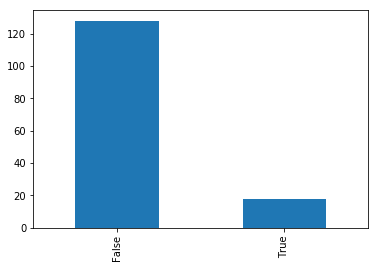

In [33]:
data_dict_df['poi'].value_counts().plot(kind='bar')

**During the validation and evaluation, I used tester.test_classifier function. This function split the dataset into features training set, labels training set, features testing set and labels testing set. Then, it fit the classifiers using training set and test it on the testing set. It also calculate and print the total predictions, accuracy, precision, recall, f1 and f2. When we try to do cross validation, we should split the dataset into training data and testing data. It's not appropriate to only randomly split one time and get one validation error to evaluate the algorithms. As we can see from the data and plot above, we have 146 observations but only 18 are people of interest. Our dataset is very small and skewed. Therefore, if I just normally split the dataset into a training set and testing set may not give a better estimation. I need to randomly split the data into multiple trials while keeping the fraction of POI  in each trials relatively constant. It's important to preserve the percentage of samples for each class. Therefore, I use StratifiedShuffleSplit. It can make training and testing indices and returns stratified randomized folds which are made by preserving the percentage of samples for each class. Its n_splits parameter is used to set the number of re-shuffling and splitting iterations, its test_size and train_size parameter is used to set size of testing set and training set, and its random_state is used to set the seed of the ramdom number generator.**

**As we can see, after tuning, Ada Boost and Gaussian Naive Bayes have better performance compared with other classifiers, especially  Gaussian Naive Bayes, so I'm going to dump this classifier.**

In [36]:
dump_classifier_and_data(clf, my_dataset, features_list)

## Summarize

**The goal of this project is to identify the Enron employees who may have committed fraud with different machine algorithms based on the public Enron financial and email dataset. There are many useful features in the datasets, financial data like the employees' salary, income and communication data like the employee's message from or to the person of interest. I've also added two new features which are messages_from_poi_ratio and messages_to_poi_ratio which could evaludate the communication between the current employee and the person of interest more specifically. Then, in order to standardize the range of features, I use feature scaling. I've also select best features based on their highest scores. I built pipeline for different classfiers and validate their results. After, I tuned different classifiers and found Gaussian Naive Bayes has the best performance on the evaluation metrics results. Finally, the classfier and data are dumped for further analysis.**